In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

np.random.seed(689503320)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay

import pickle

In [2]:
# Load data splits

data_train_unscaled = pd.read_csv('../data/data_train_unscaled.csv')
data_test = pd.read_csv('../data/data_test.csv')

data_train_0 = pd.read_csv('../data/data_train_0.csv')
data_train_1 = pd.read_csv('../data/data_train_1.csv')
data_train_2 = pd.read_csv('../data/data_train_2.csv')
data_train_3 = pd.read_csv('../data/data_train_3.csv')
data_train_4 = pd.read_csv('../data/data_train_4.csv')

data_holdout_0 = pd.read_csv('../data/data_holdout_0.csv')
data_holdout_1 = pd.read_csv('../data/data_holdout_1.csv')
data_holdout_2 = pd.read_csv('../data/data_holdout_2.csv')
data_holdout_3 = pd.read_csv('../data/data_holdout_3.csv')
data_holdout_4 = pd.read_csv('../data/data_holdout_4.csv')

data_train_all = pd.concat([data_train_0, data_holdout_0])

training_datasets = [data_train_0, data_train_1, data_train_2, data_train_3, data_train_4]
holdout_datasets = [data_holdout_0, data_holdout_1, data_holdout_2, data_holdout_3, data_holdout_4]

In [3]:
data_train_unscaled.columns

Index(['State', 'County', 'FIPS', 'PERPOV10', 'METRO13', 'SNAPSPTH17',
       'REDEMP_SNAPS17', 'PCT_SNAP17', 'PC_SNAPBEN17', 'PCT_NSLP17',
       'PCT_SBP17', 'PCT_SFSP17', 'PCT_WIC17', 'PCT_CACFP17',
       'PCT_OBESE_ADULTS17', 'GROCPTH16', 'SUPERCPTH16', 'CONVSPTH16',
       'SPECSPTH16', 'WICSPTH16', 'FFRPTH16', 'FSRPTH16', 'PC_WIC_REDEMP16',
       'REDEMP_WICS16', 'PCT_WICINFANTCHILD16', 'PCT_WICWOMEN16',
       'RECFACPTH16', 'POVRATE15', 'MEDHHINC15', 'FDPIR15',
       'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15',
       'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'PopulationEstimate2017',
       'LogPopulationEstimate2017', 'LogTransformedFDPIR15',
       'LogTransformedGROCPTH16', 'LogTransformedSUPERCPTH16',
       'LogTransformedCONVSPTH16', 'LogTransformedSPECSPTH16',
       'LogTransformedWICSPTH16', 'LogTransformedFFRPTH16',
       'LogTransformedFSRPTH16', 'LogTransformedRECFACPTH16'],
      dtype='object')

In [4]:
# Excluding poverty rate and median household income which determine poverty status

potential_features = ['SNAPSPTH17', 'REDEMP_SNAPS17', 'PCT_SNAP17', 'PC_SNAPBEN17', 'PCT_NSLP17', 'PCT_SBP17', 'PCT_SFSP17', 'PCT_WIC17', 'PCT_CACFP17',
            'PCT_OBESE_ADULTS17', 'PC_WIC_REDEMP16', 'REDEMP_WICS16', 'PCT_WICINFANTCHILD16', 'PCT_WICWOMEN16',
            'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'LogPopulationEstimate2017',
            'LogTransformedFDPIR15', 'LogTransformedGROCPTH16', 'LogTransformedSUPERCPTH16', 'LogTransformedCONVSPTH16', 'LogTransformedSPECSPTH16', 
            'LogTransformedWICSPTH16', 'LogTransformedFFRPTH16', 'LogTransformedFSRPTH16', 'LogTransformedRECFACPTH16']

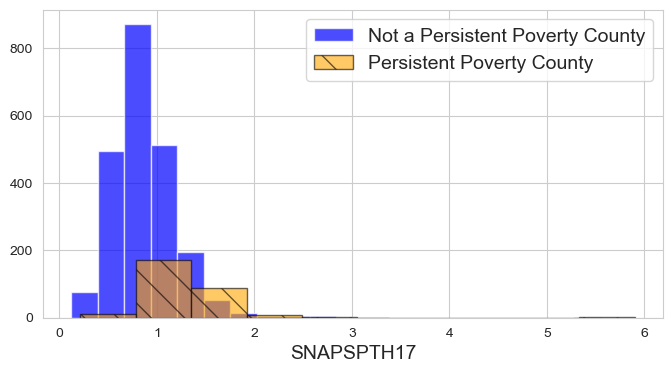

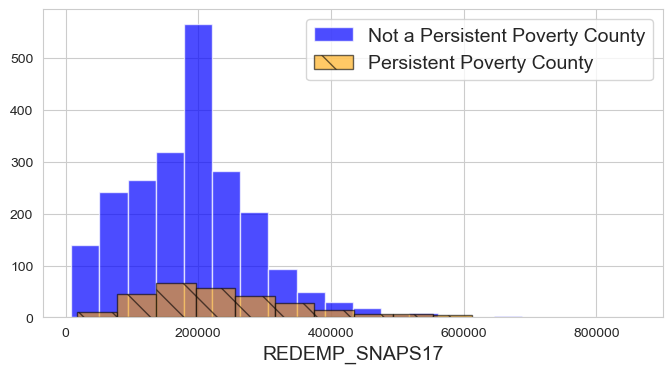

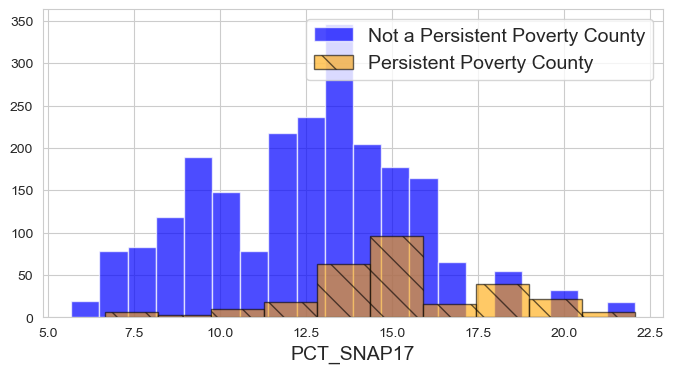

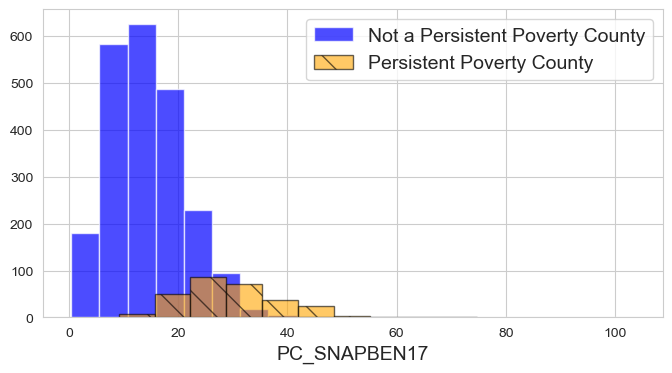

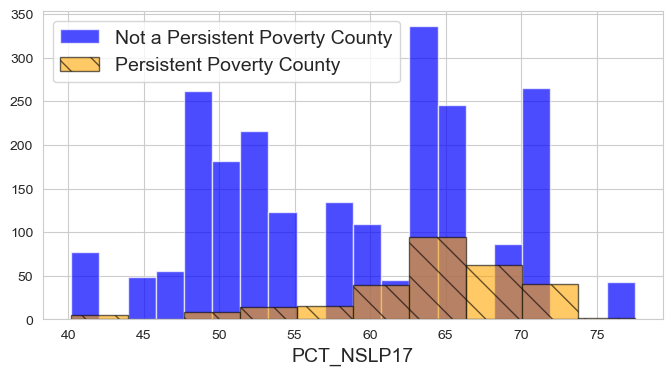

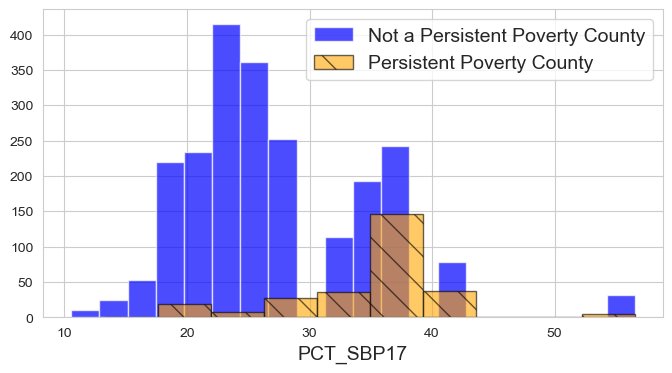

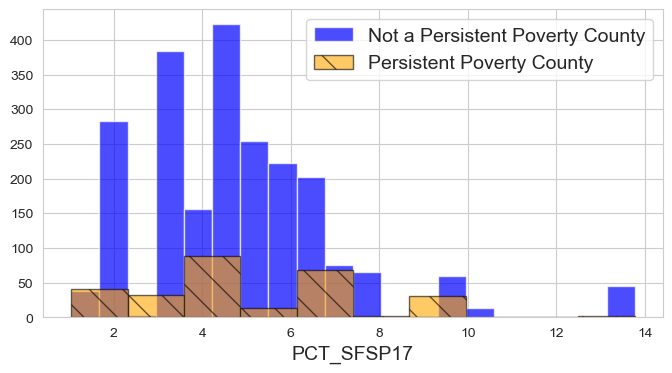

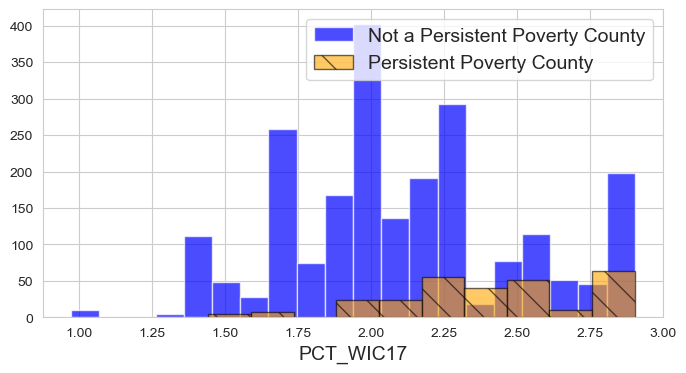

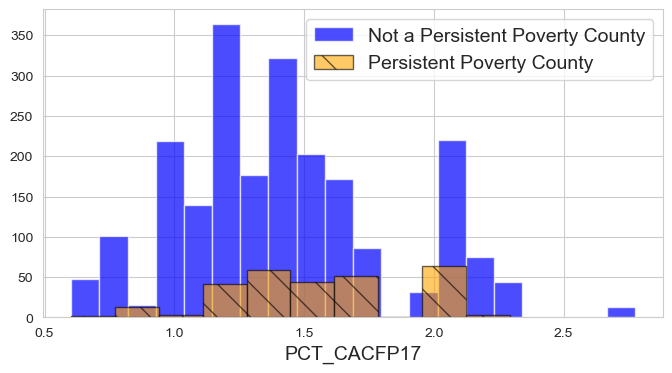

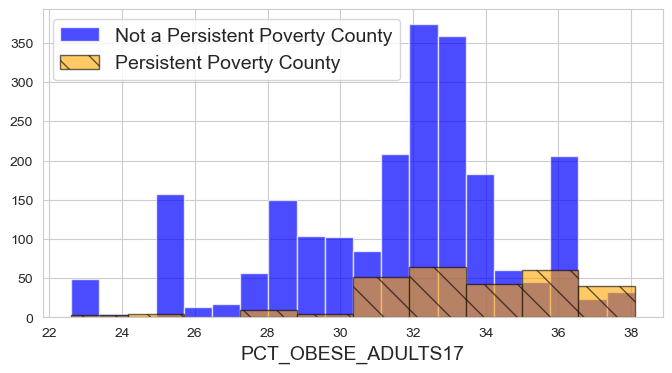

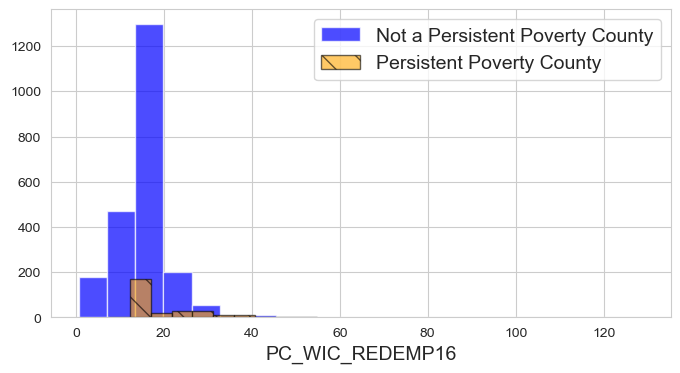

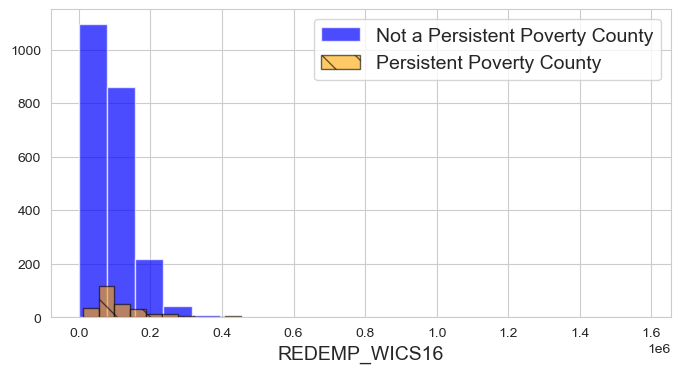

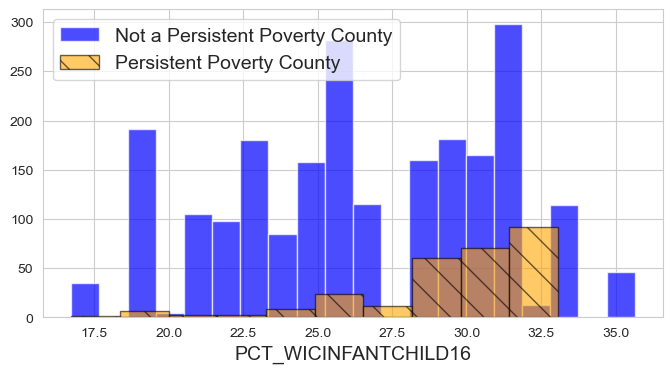

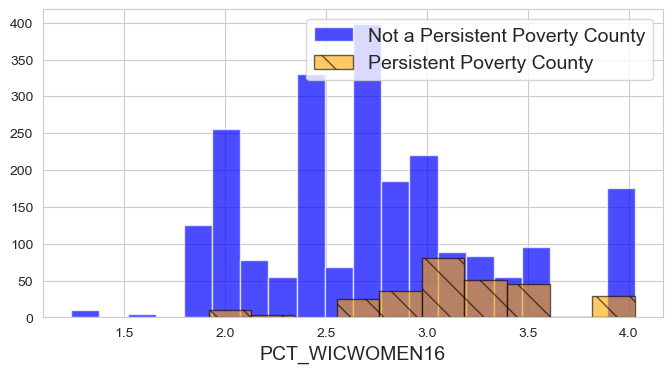

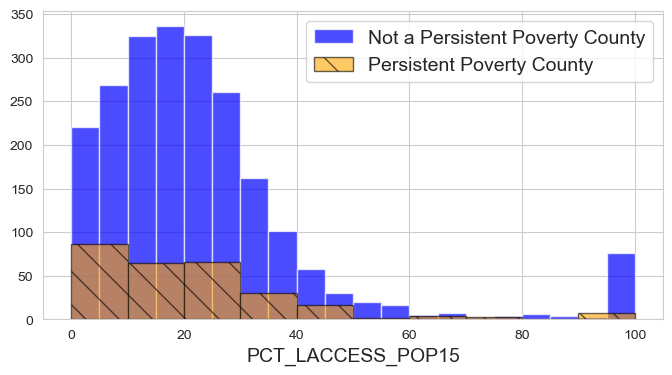

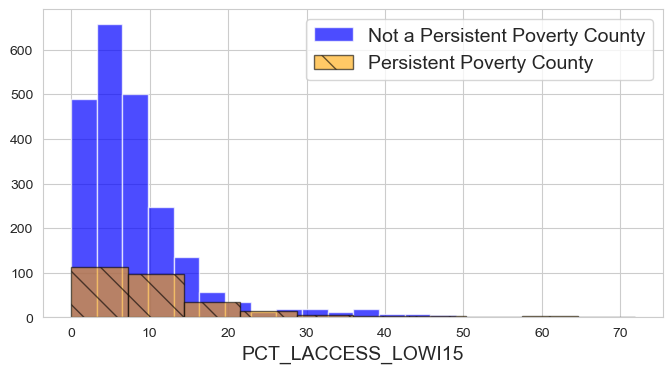

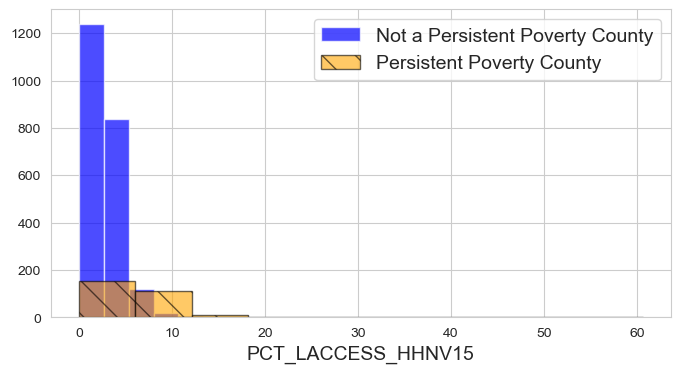

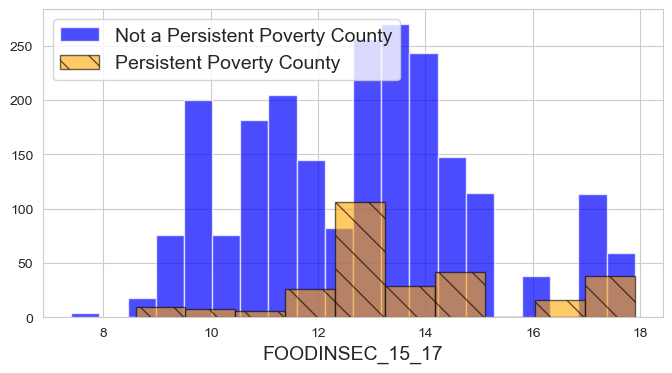

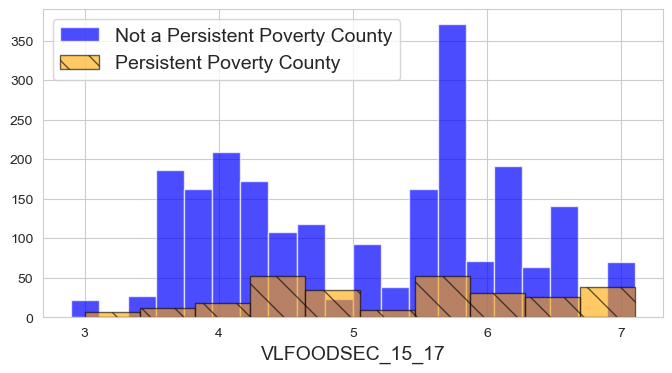

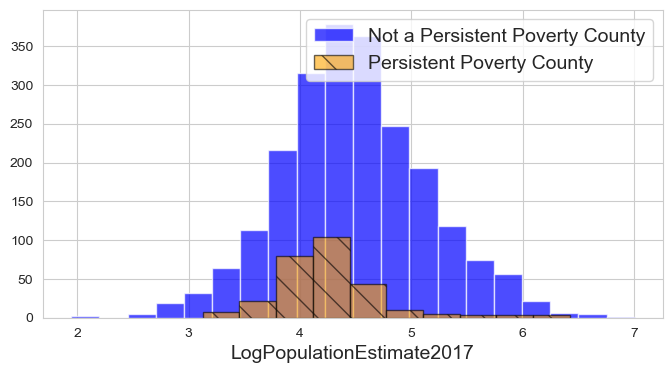

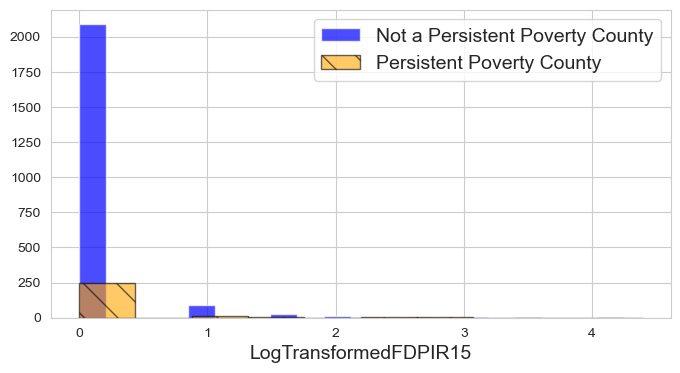

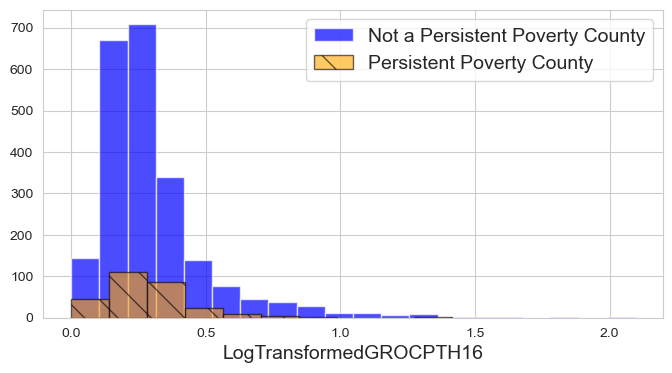

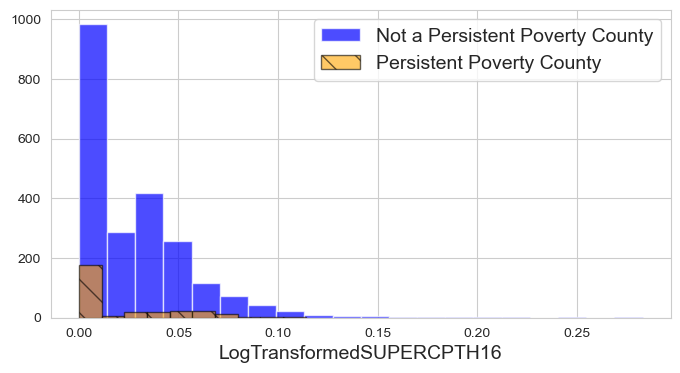

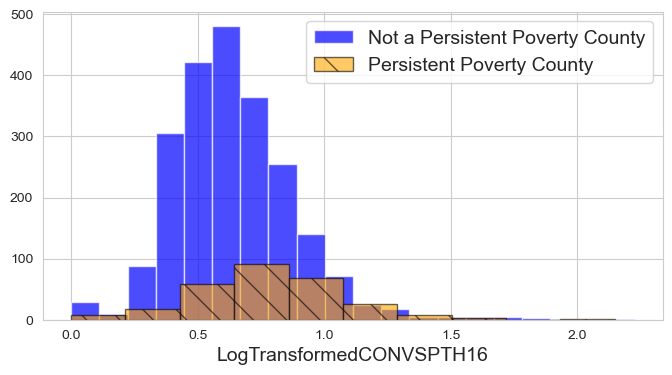

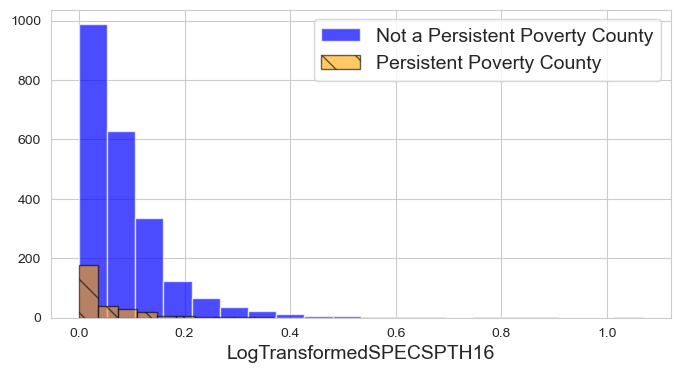

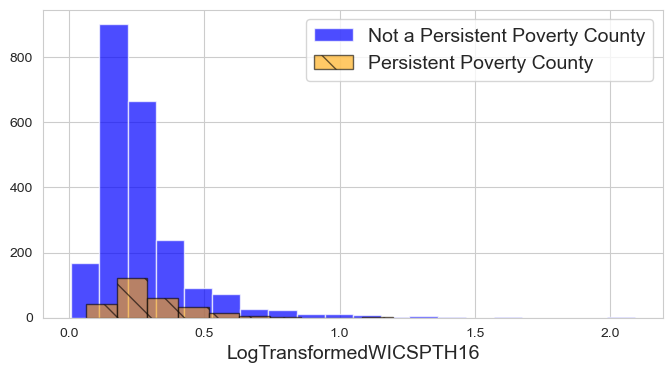

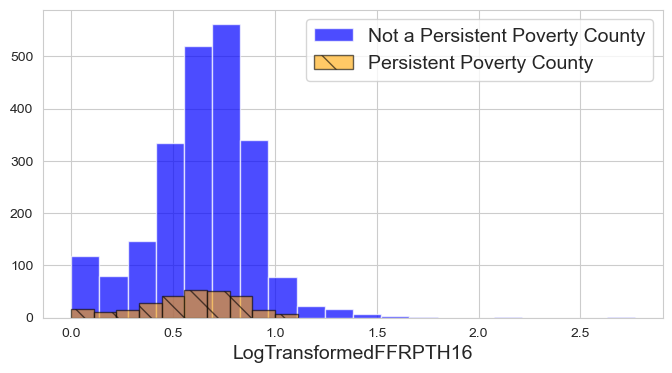

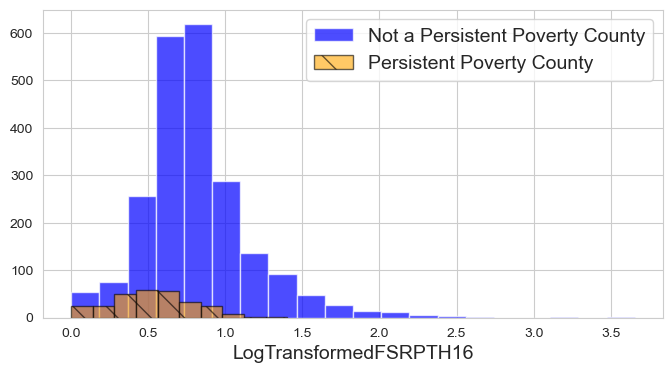

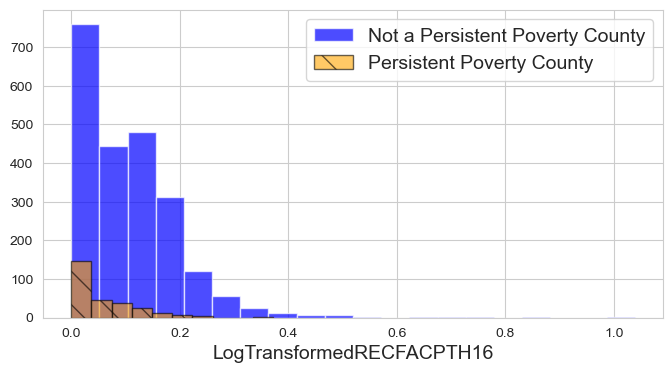

In [5]:
for feature in potential_features:
    plt.figure(figsize=(8,4))

    plt.hist(data_train_unscaled.loc[data_train_unscaled.PERPOV10 == 0, feature].values,
                bins=20,
                color='blue',
                alpha=.7,
                label="Not a Persistent Poverty County")

    plt.hist(data_train_unscaled.loc[data_train_unscaled.PERPOV10 == 1, feature].values,
                bins=10,
                color='orange',
                alpha=.6,
                hatch = '\\',
                edgecolor='black',
                label="Persistent Poverty County")

    plt.xlabel(feature, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

In [6]:
# Choose features that appear to be strongly separating, weakly separating, and non-separating

strongly_separating_features = ['PC_SNAPBEN17', 'PCT_NSLP17', 'PCT_SBP17', 'PCT_WICINFANTCHILD16', 'PCT_WICWOMEN16',
                                'LogTransformedCONVSPTH16', 'LogTransformedFSRPTH16']
weakly_separating_features = ['SNAPSPTH17', 'REDEMP_SNAPS17', 'PCT_SNAP17', 'PCT_SFSP17', 'PCT_WIC17', 'PCT_OBESE_ADULTS17',
                              'PCT_LACCESS_HHNV15', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'LogPopulationEstimate2017', 'LogTransformedRECFACPTH16']
non_separating_features = ['PCT_CACFP17', 'PC_WIC_REDEMP16', 'REDEMP_WICS16', 'PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'LogTransformedFDPIR15', 
                           'LogTransformedGROCPTH16', 'LogTransformedSUPERCPTH16', 'LogTransformedSPECSPTH16', 'LogTransformedWICSPTH16',
                          'LogTransformedFFRPTH16']
separating_features = strongly_separating_features + weakly_separating_features
all_features = potential_features.copy()

In [7]:
# Model training and analysis
num_k_splits = len(training_datasets)
predicted_proba = []

## Used for baseline model
ppov = data_train_unscaled.PERPOV10.loc[data_train_unscaled.PERPOV10 == 1].count()
nonppov = data_train_unscaled.PERPOV10.loc[data_train_unscaled.PERPOV10 == 0].count()
ppov_prop = ppov/(ppov + nonppov)

for j in range(num_k_splits):
    data_tt = training_datasets[j]
    data_ho = holdout_datasets[j]
    l = len(data_ho)
        
    # Baseline model: Random classifier
    indices = np.random.choice(range(l),int(ppov_prop*l),replace=False)
    pred_baseline = np.zeros(len(data_ho))
    for a in indices:
        pred_baseline[a] = 1
    
    # Models 1-3: Multiple Logistic Regression
    model1 = LogisticRegression()
    model1.fit(data_tt[strongly_separating_features], data_tt.PERPOV10.values)
    model2 = LogisticRegression()
    model2.fit(data_tt[separating_features], data_tt.PERPOV10.values)
    model3 = LogisticRegression()
    model3.fit(data_tt[all_features], data_tt.PERPOV10.values)

    # Models 4-6: Linear Discriminant Analysis
    model4 = LinearDiscriminantAnalysis()
    model4.fit(data_tt[strongly_separating_features], data_tt.PERPOV10.values)
    model5 = LinearDiscriminantAnalysis()
    model5.fit(data_tt[separating_features], data_tt.PERPOV10.values)
    model6 = LinearDiscriminantAnalysis()
    model6.fit(data_tt[all_features], data_tt.PERPOV10.values)

    # Models 7-9: Quadratic Discriminant Analysis
    model7 = QuadraticDiscriminantAnalysis()
    model7.fit(data_tt[strongly_separating_features], data_tt.PERPOV10.values)
    model8 = QuadraticDiscriminantAnalysis()
    model8.fit(data_tt[separating_features], data_tt.PERPOV10.values)
    model9 = QuadraticDiscriminantAnalysis()
    model9.fit(data_tt[all_features], data_tt.PERPOV10.values)

    # Model 10-12: Re-creating the Random Forest Classifier from Omeiza's analysis
    model10 = RandomForestClassifier()
    model10.fit(data_tt[strongly_separating_features], data_tt.PERPOV10.values)
    model11 = RandomForestClassifier()
    model11.fit(data_tt[separating_features], data_tt.PERPOV10.values)
    model12 = RandomForestClassifier()
    model12.fit(data_tt[all_features], data_tt.PERPOV10.values)

    # Model predictions
    pred1 = model1.predict_proba(data_ho[strongly_separating_features])[:,1]
    pred2 = model2.predict_proba(data_ho[separating_features])[:,1]
    pred3 = model3.predict_proba(data_ho[all_features])[:,1]
    pred4 = model4.predict_proba(data_ho[strongly_separating_features])[:,1]
    pred5 = model5.predict_proba(data_ho[separating_features])[:,1]
    pred6 = model6.predict_proba(data_ho[all_features])[:,1]
    pred7 = model7.predict_proba(data_ho[strongly_separating_features])[:,1]
    pred8 = model8.predict_proba(data_ho[separating_features])[:,1]
    pred9 = model9.predict_proba(data_ho[all_features])[:,1]
    pred10 = model10.predict_proba(data_ho[strongly_separating_features])[:,1]
    pred11 = model11.predict_proba(data_ho[separating_features])[:,1]
    pred12 = model12.predict_proba(data_ho[all_features])[:,1]

    predicted_proba.append([pred_baseline, pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10, pred11, pred12])

all_proba = [[predicted_proba[j][i] for j in range(5)] for i in range(len(predicted_proba[0]))]
concat_proba = [np.concatenate([all_proba[i][0], all_proba[i][1], all_proba[i][2], all_proba[i][3], all_proba[i][4]], axis=0) for i in range(len(all_proba))]

model_names = ['Baseline (Random Classifier)', 'Logistic Regression (7 Predictors)', 'Logistic Regression (18 Predictors)', 
               'Logistic Regression (29 Predictors)', 'LDA (7 Predictors)', 'LDA (18 Predictors)', 'LDA (29 Predictors)', 
               'QDA (7 Predictors)', 'QDA (18 Predictors)', 'QDA (29 Predictors)', 'Random Forest (7 Predictors)', 
               'Random Forest (18 Predictors)', 'Random Forest (29 Predictors)']

In [8]:
# Evaluate prediction probabilities with a given threshold
def get_metrics(predicted_proba, threshold):
    all_predictions = [[1*(proba > threshold) for proba in all_proba[i]] for i in range(len(all_proba))]
    all_accuracies = [[100*accuracy_score(all_predictions[i][j], holdout_datasets[j].PERPOV10) for j in range(len(all_predictions[i]))] for i in range(len(all_predictions))]
    # We also want to identify e.g. when a model predicts everything as 0
    all_frequencies = [[100*prediction.sum()/len(prediction) for prediction in all_predictions[i]] for i in range(len(all_predictions))]

    accuracies = [np.round((acc[0] + acc[1] + acc[2] + acc[3] + acc[4])/5, 2) for acc in all_accuracies]
    frequencies = [np.round((freq[0] + freq[1] + freq[2] + freq[3] + freq[4])/5, 2) for freq in all_frequencies]
    return all_predictions, accuracies, frequencies

In [9]:
# Comparing accuracy for a few different thresholds

threshold = 0.15
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [80.69, 73.61, 71.18]
% predicted by logistic regression as 1:  [10.15, 21.69, 24.92] 

LDA accuracy scores:  [81.89, 74.45, 72.41]
% predicted by LDA as 1:  [8.48, 20.38, 23.29] 

QDA accuracy:  [68.43, 70.26, 68.31]
% predicted by QDA as 1:  [27.43, 27.27, 32.4] 

Random Forest accuracy:  [82.81, 82.49, 82.17]
% predicted by Random Forest as 1:  [21.81, 23.56, 23.16] 



In [10]:
threshold = 0.17
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [86.15, 80.41, 77.39]
% predicted by logistic regression as 1:  [3.11, 11.31, 15.53] 

LDA accuracy scores:  [86.42, 80.62, 78.06]
% predicted by LDA as 1:  [2.51, 10.95, 14.61] 

QDA accuracy:  [75.0, 72.89, 70.62]
% predicted by QDA as 1:  [17.84, 23.77, 29.46] 

Random Forest accuracy:  [84.52, 84.32, 85.0]
% predicted by Random Forest as 1:  [19.62, 20.53, 19.86] 



In [11]:
threshold = 0.2
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [87.62, 85.75, 83.92]
% predicted by logistic regression as 1:  [0.36, 2.95, 6.77] 

LDA accuracy scores:  [87.78, 85.51, 83.8]
% predicted by LDA as 1:  [0.2, 3.34, 7.05] 

QDA accuracy:  [81.13, 76.19, 72.93]
% predicted by QDA as 1:  [9.4, 18.63, 26.27] 

Random Forest accuracy:  [87.58, 87.66, 88.58]
% predicted by Random Forest as 1:  [16.24, 16.47, 15.4] 



In [12]:
threshold = 0.25
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [87.9, 87.7, 86.9]
% predicted by logistic regression as 1:  [0.0, 0.52, 2.03] 

LDA accuracy scores:  [87.9, 87.78, 86.74]
% predicted by LDA as 1:  [0.0, 0.52, 2.43] 

QDA accuracy:  [85.03, 80.49, 75.96]
% predicted by QDA as 1:  [4.3, 12.66, 22.21] 

Random Forest accuracy:  [90.09, 90.69, 92.0]
% predicted by Random Forest as 1:  [13.01, 12.5, 10.86] 



In [13]:
threshold = 0.3
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [87.9, 87.94, 87.7]
% predicted by logistic regression as 1:  [0.0, 0.28, 0.92] 

LDA accuracy scores:  [87.9, 87.94, 87.66]
% predicted by LDA as 1:  [0.0, 0.28, 1.04] 

QDA accuracy:  [86.39, 82.61, 79.42]
% predicted by QDA as 1:  [2.63, 9.35, 17.79] 

Random Forest accuracy:  [91.88, 93.03, 93.71]
% predicted by Random Forest as 1:  [10.9, 9.75, 8.84] 



In [14]:
threshold = 0.4
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [87.9, 87.9, 87.98]
% predicted by logistic regression as 1:  [0.0, 0.0, 0.32] 

LDA accuracy scores:  [87.9, 87.98, 87.86]
% predicted by LDA as 1:  [0.0, 0.08, 0.6] 

QDA accuracy:  [86.78, 85.08, 82.49]
% predicted by QDA as 1:  [1.67, 5.13, 12.66] 

Random Forest accuracy:  [93.63, 94.51, 94.63]
% predicted by Random Forest as 1:  [8.76, 7.56, 7.44] 



In [15]:
threshold = 0.5
all_predictions, accuracies, frequencies = get_metrics(predicted_proba, threshold)

print('Baseline mean accuracy score: ', accuracies[0], '%')
print('% positives predicted by baseline: ', frequencies[0], '%\n')

# Model accuracy
print('Logistic regression accuracy scores: ', accuracies[1:4])
print('% predicted by logistic regression as 1: ', frequencies[1:4] , '\n')

print('LDA accuracy scores: ', accuracies[4:7])
print('% predicted by LDA as 1: ', frequencies[4:7], '\n')

print('QDA accuracy: ', accuracies[7:10])
print('% predicted by QDA as 1: ', frequencies[7:10], '\n')

print('Random Forest accuracy: ', accuracies[10:13])
print('% predicted by Random Forest as 1: ', frequencies[10:13], '\n')

Baseline mean accuracy score:  79.26 %
% positives predicted by baseline:  11.11 %

Logistic regression accuracy scores:  [87.9, 87.9, 87.86]
% predicted by logistic regression as 1:  [0.0, 0.0, 0.04] 

LDA accuracy scores:  [87.9, 87.94, 87.94]
% predicted by LDA as 1:  [0.0, 0.04, 0.36] 

QDA accuracy:  [87.26, 85.55, 83.96]
% predicted by QDA as 1:  [1.03, 3.78, 9.59] 

Random Forest accuracy:  [94.07, 94.82, 94.94]
% predicted by Random Forest as 1:  [7.92, 7.16, 7.05] 



In [16]:
# Plot accuracy vs. response frequency
thresholds = np.linspace(0.005, 0.5, 100)
all_metrics = np.array([get_metrics(predicted_proba, threshold)[1:] for threshold in thresholds])

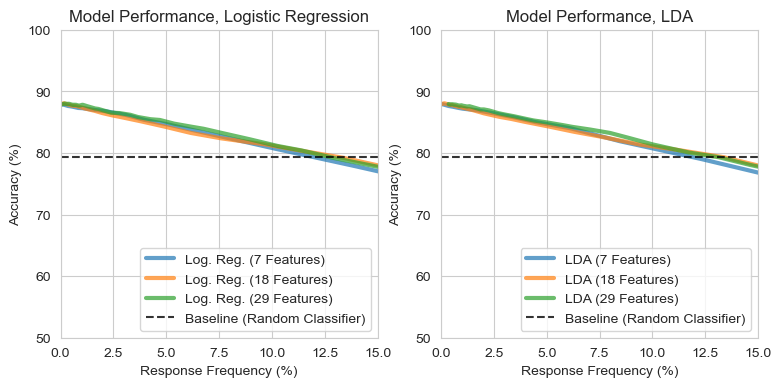

In [17]:
# Logistic Regression models
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0].plot(all_metrics[:,1,1],all_metrics[:,0,1], alpha = 0.7, linewidth=3.0)
ax[0].plot(all_metrics[:,1,2],all_metrics[:,0,2], alpha = 0.7, linewidth=3.0)
ax[0].plot(all_metrics[:,1,3],all_metrics[:,0,3], alpha = 0.7, linewidth=3.0)
ax[0].plot(np.linspace(0, 100, 100), all_metrics[:,0,0], c = 'black', linestyle='dashed', alpha = 0.8, linewidth=1.5)

ax[0].set_xlim(0,15)
ax[0].set_ylim(50,100)
ax[0].set_title('Model Performance, Logistic Regression')
ax[0].set_xlabel('Response Frequency (%)')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend(['Log. Reg. (7 Features)', 'Log. Reg. (18 Features)', 'Log. Reg. (29 Features)', 'Baseline (Random Classifier)'], loc='lower right')

# LDA models
ax[1].plot(all_metrics[:,1,4],all_metrics[:,0,4], alpha = 0.7, linewidth=3.0)
ax[1].plot(all_metrics[:,1,5],all_metrics[:,0,5], alpha = 0.7, linewidth=3.0)
ax[1].plot(all_metrics[:,1,6],all_metrics[:,0,6], alpha = 0.7, linewidth=3.0)
ax[1].plot(np.linspace(0, 100, 100), all_metrics[:,0,0], c = 'black', linestyle='dashed', alpha = 0.8, linewidth=1.5)

ax[1].set_xlim(0,15)
ax[1].set_ylim(50,100)
ax[1].set_title('Model Performance, LDA')
ax[1].set_xlabel('Response Frequency (%)')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['LDA (7 Features)', 'LDA (18 Features)', 'LDA (29 Features)', 'Baseline (Random Classifier)'], loc='lower right')


plt.show()

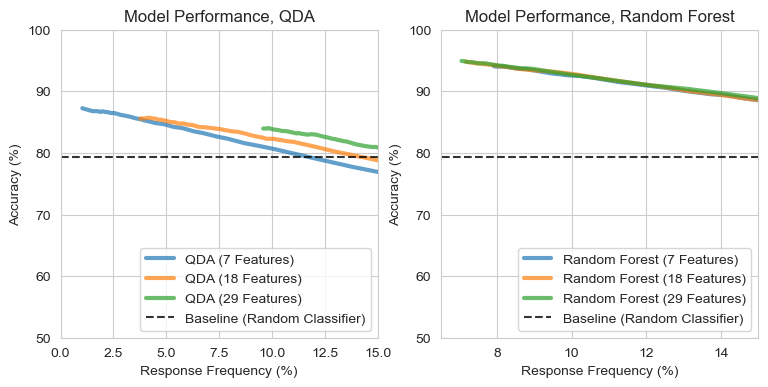

In [18]:
# QDA models
fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0].plot(all_metrics[:,1,7],all_metrics[:,0,7], alpha = 0.7, linewidth=3.0)
ax[0].plot(all_metrics[:,1,8],all_metrics[:,0,8], alpha = 0.7, linewidth=3.0)
ax[0].plot(all_metrics[:,1,9],all_metrics[:,0,9], alpha = 0.7, linewidth=3.0)
ax[0].plot(np.linspace(0, 100, 100), all_metrics[:,0,0], c = 'black', linestyle='dashed', alpha = 0.8, linewidth=1.5)

ax[0].set_xlim(0,15)
ax[0].set_ylim(50,100)
ax[0].set_title('Model Performance, QDA')
ax[0].set_xlabel('Response Frequency (%)')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend(['QDA (7 Features)', 'QDA (18 Features)', 'QDA (29 Features)', 'Baseline (Random Classifier)'], loc='lower right')

# LDA models
ax[1].plot(all_metrics[:,1,10],all_metrics[:,0,10], alpha = 0.7, linewidth=3.0)
ax[1].plot(all_metrics[:,1,11],all_metrics[:,0,11], alpha = 0.7, linewidth=3.0)
ax[1].plot(all_metrics[:,1,12],all_metrics[:,0,12], alpha = 0.7, linewidth=3.0)
ax[1].plot(np.linspace(0, 100, 100), all_metrics[:,0,0], c = 'black', linestyle='dashed', alpha = 0.8, linewidth=1.5)

ax[1].set_xlim(6.5,15)
ax[1].set_ylim(50,100)
ax[1].set_title('Model Performance, Random Forest')
ax[1].set_xlabel('Response Frequency (%)')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Random Forest (7 Features)', 'Random Forest (18 Features)', 'Random Forest (29 Features)', 'Baseline (Random Classifier)'], loc='lower right')


plt.show()

In [19]:
# Find the optimal threshold that has over 11% of counties predicted as persistent poverty counties (current poverty rate is 11.6%)
min_frequency = 11
for model_number in range(len(model_names)):
    filtered_metrics = np.array([[model_number, np.round(thresholds[threshold_number], 3), all_metrics[threshold_number,0,model_number]] 
                                 for threshold_number in range(len(thresholds)) 
                                 if all_metrics[threshold_number,1,model_number] >= min_frequency])
    ind_of_best_acc = np.argmax(filtered_metrics[:,2])
    print(model_names[model_number], ': optimized at a threshold of', filtered_metrics[ind_of_best_acc,1], 'with an accuracy of', filtered_metrics[ind_of_best_acc,2], '%' )

Baseline (Random Classifier) : optimized at a threshold of 0.005 with an accuracy of 79.26 %
Logistic Regression (7 Predictors) : optimized at a threshold of 0.145 with an accuracy of 77.86 %
Logistic Regression (18 Predictors) : optimized at a threshold of 0.17 with an accuracy of 80.41 %
Logistic Regression (29 Predictors) : optimized at a threshold of 0.18 with an accuracy of 80.41 %
LDA (7 Predictors) : optimized at a threshold of 0.145 with an accuracy of 79.02 %
LDA (18 Predictors) : optimized at a threshold of 0.165 with an accuracy of 79.3 %
LDA (29 Predictors) : optimized at a threshold of 0.18 with an accuracy of 80.05 %
QDA (7 Predictors) : optimized at a threshold of 0.185 with an accuracy of 78.78 %
QDA (18 Predictors) : optimized at a threshold of 0.27 with an accuracy of 81.77 %
QDA (29 Predictors) : optimized at a threshold of 0.44 with an accuracy of 83.24 %
Random Forest (7 Predictors) : optimized at a threshold of 0.29 with an accuracy of 91.52 %
Random Forest (18 Pr

In [20]:
# TBD: Best model is Random Forest on a selection of 18 features
final_model = RandomForestClassifier()
final_model.fit(data_train_all[separating_features], data_train_all.PERPOV10.values)
proba = final_model.predict_proba(data_test[separating_features])
threshold = 0.27

pred = 1*(proba[:,1] > threshold)
acc = np.round(100*accuracy_score(pred, data_test.PERPOV10),2)
freq = np.round(100*pred.sum()/len(pred),2)

print('Random Forest Classifier on 18 selected features\n', 
      'Prediction Threshold:', threshold, '\n\n',
      'Accuracy on test set:', acc, '%\n',
      'Frequency of counties predicted as persistent-poverty:', freq, '%')

Random Forest Classifier on 18 selected features
 Prediction Threshold: 0.27 

 Accuracy on test set: 92.06 %
 Frequency of counties predicted as persistent-poverty: 9.84 %


In [21]:
# Save trained model
with open('persistent_poverty_rf_classifier.pkl','wb') as file:
    pickle.dump(final_model,file)